# Introduction to RNNs: learning the alphabet

A simple example to understand how Recurrent Neural Networks learn sequential patterns.

## Key concepts

- **Sequence learning**: RNNs process input one step at a time, maintaining a "memory" (hidden state) of what they've seen.
- **Next-character prediction**: Given a sequence like `['a', 'b', 'c']`, predict the next character (`'d'`).
- **Hidden state**: The internal memory that carries information from previous timesteps (or indexes) in a sequence.

## How the RNN processes a sequence

Given input `['a', 'b', 'c']`, the RNN predicts `'d'`:

```
                     ┌─◀──────┐ 'h₁', then 'h₂'
                     │        ▲ 
                     ▼        |
                    ┌──────────┐
                    |          |         ┌───────┐
'a', then 'b', ────▶|   RNN    |──'h₃'──▶│ Dense │ ────▶ 'c'
   then 'c'         |          |         └───────┘ 
                    └──────────┘



h₁ = RNN('a', h₀)        # h₁ "knows" about 'a'
h₂ = RNN('b', h₁)        # h₂ "knows" about 'a', 'b'  
h₃ = RNN('c', h₂)        # h₃ "knows" about 'a', 'b', 'c'

output = Dense(h₃) → 'd' # Final hidden state predicts next char
```

The same RNN weights are used at each step within a sequence — only the hidden state changes.

## Setup

### Imports

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical

### Configuration

In [11]:
# Force CPU only
tf.config.set_visible_devices([], 'GPU')

## 1. Create the alphabet dataset

In [12]:
# Create alphabet mapping
alphabet = 'abcdefghijklmnopqrstuvwxyz'
char_to_idx = {c: i for i, c in enumerate(alphabet)}
idx_to_char = {i: c for i, c in enumerate(alphabet)}
vocab_size = len(alphabet)

print(f'Vocabulary: {alphabet}')
print(f'Vocabulary size: {vocab_size}')

print('\nMappings:\n')

for key, val in char_to_idx.items():
    print(f' {key} -> {val}')

Vocabulary: abcdefghijklmnopqrstuvwxyz
Vocabulary size: 26

Mappings:

 a -> 0
 b -> 1
 c -> 2
 d -> 3
 e -> 4
 f -> 5
 g -> 6
 h -> 7
 i -> 8
 j -> 9
 k -> 10
 l -> 11
 m -> 12
 n -> 13
 o -> 14
 p -> 15
 q -> 16
 r -> 17
 s -> 18
 t -> 19
 u -> 20
 v -> 21
 w -> 22
 x -> 23
 y -> 24
 z -> 25


In [13]:
# Create training sequences
# Input: sequence of 3 letters, Output: the next letter
seq_length = 3

X = []  # Input sequences
y = []  # Target (next character)

for i in range(len(alphabet) - seq_length):

    # Input: 3 consecutive letters as indices
    seq_in = [char_to_idx[c] for c in alphabet[i:i+seq_length]]

    # Output: the next letter's index
    seq_out = char_to_idx[alphabet[i+seq_length]]
    X.append(seq_in)
    y.append(seq_out)

X = np.array(X)
y = np.array(y)

# Convert to one-hot encoding
# Shape goes from (23, 3) to (23, 3, 26)
X_onehot = to_categorical(X, num_classes=vocab_size)

print(f'Training samples: {len(X)}')
print(f'X shape (indices): {X.shape}')
print(f'X shape (one-hot): {X_onehot.shape}')
print(f'y shape: {y.shape}')

print('\nExamples:\n')

for i in range(3):
    print(f' {[idx_to_char[j] for j in X[i]]} -> {idx_to_char[y[i]]}')

print(f"\nOne-hot for 'a' (index 0): {X_onehot[0, 0, :5]}... (first 5 of 26)")
print(f"One-hot for 'b' (index 1): {X_onehot[0, 1, :5]}... (first 5 of 26)")

Training samples: 23
X shape (indices): (23, 3)
X shape (one-hot): (23, 3, 26)
y shape: (23,)

Examples:

 ['a', 'b', 'c'] -> d
 ['b', 'c', 'd'] -> e
 ['c', 'd', 'e'] -> f

One-hot for 'a' (index 0): [1. 0. 0. 0. 0.]... (first 5 of 26)
One-hot for 'b' (index 1): [0. 1. 0. 0. 0.]... (first 5 of 26)


## 2. Build the RNN model

A simple architecture:
1. **Input**: One-hot encoded characters (26-dimensional vectors)
2. **SimpleRNN**: Process the sequence, output final hidden state  
3. **Dense**: Predict the next character

With one-hot encoding, each input character is a vector of 26 zeros with a single 1 at the character's index position.

In [14]:
# Model parameters
hidden_dim = 8 # RNN hidden state size

model = Sequential([
    SimpleRNN(hidden_dim, input_shape=(seq_length, vocab_size)),
    Dense(vocab_size, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 280       
                                                                 
 dense_1 (Dense)             (None, 26)                234       
                                                                 
Total params: 514 (2.01 KB)
Trainable params: 514 (2.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 3. Train the model

In [15]:
history = model.fit(
    X_onehot, y,  # Use one-hot encoded input
    epochs=300,
    batch_size=4,
    verbose=0
)

## 4. Learning curves

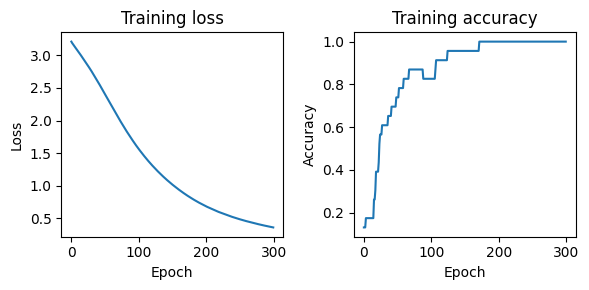

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].plot(history.history['loss'])
axes[0].set_title('Training loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(history.history['accuracy'])
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

## 5. Test the model

In [17]:
def predict_next(chars, model):
    '''Predict the next character given a sequence.'''

    indices = np.array([[char_to_idx[c] for c in chars]])
    onehot = to_categorical(indices, num_classes=vocab_size)
    pred = model.predict(onehot, verbose=0)
    next_idx = np.argmax(pred)

    return idx_to_char[next_idx]

In [18]:
# Test predictions
test_sequences = ['abc', 'def', 'mno', 'stu', 'wxy']

print('Predictions:\n')

for seq in test_sequences:
    if len(seq) == seq_length and all(c in char_to_idx for c in seq):
        pred = predict_next(seq, model)
        print(f'  {seq} -> {pred}')

Predictions:

  abc -> d
  def -> g
  mno -> p
  stu -> v
  wxy -> z
